In [16]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
class ARGS():
    def __init__(self):
        self.mother_list = ['Llama-2-7b-hf','Qwen-1_8B','falcon-7b','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','mpt-7b','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        # self.models = ['Llama-2-7b-hf','Qwen-1_8B','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        self.sub_list = ['Yi-34B','Qwen-72B','Qwen-14B','Llama-2-70b-hf','deepseek-llm-67b-base','Yi-6B']
        self.indices = [self.mother_list.index(item) for item in self.sub_list]
        self.logits_data_dir = "D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/outputs_base"
        self.raw_data_dir = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data'
        self.data_names = ['mmlu_10k', 'cosmosqa_10k', 'hellaswag_10k', 'halu_dialogue', 'halu_summarization']
        self.tasks = {'mmlu_10k':'QA', 'cosmosqa_10k':'RC', 'hellaswag_10k':'CI', 'halu_dialogue':'DRS', 'halu_summarization':'DS'}
        self.alpha = 0.1
args = ARGS()


In [2]:
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result
def get_SPU(args, data_name, models=args.mother_list):
    """
    0~5:softmax score for option
    """
    SPU = {}
    for model in models:
        logits_file = os.path.join(args.logits_data_dir, model+"_"+data_name+"_base_icl1.pkl")
        with open(logits_file, 'rb') as f:
            logits_data = pickle.load(f)
        softmax_data = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_data)]))
        # softmax_data[:, 4] += softmax_data[:, 5]
        # softmax_data[:, 5] = np.var(softmax_data[:, :4], axis=1)
        # softmax_data = np.column_stack((softmax_data, np.var(softmax_data[:, :4], axis=1)))
        # softmax_pred_data = np.column_stack((softmax_data, np.argmax(softmax_data[:, :4], axis=1)))
        # softmax_pred_uncertainty_data = np.column_stack((softmax_pred_data, 1 - np.max(softmax_pred_data[:,:4], axis=1)))
        SPU[model] = softmax_data
    # return SPU, softmax_pred_uncertainty_data.shape[-1], softmax_pred_data.shape[-1]-1
    return SPU
def get_raw_data(args):
    mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    raw_data_all = []
    for data_name in args.data_names:
        raw_data = json.load(open(os.path.join(args.raw_data_dir, data_name + ".json"), "r"))
        arr = np.array([item['answer'] for _, item in enumerate(raw_data)])
        mapped_array = np.vectorize(mapping.get)(arr)
        raw_data_all.append(mapped_array)
    return np.array(raw_data_all)
def get_combined_feature(SPU, models, num_model_feature = 6, col_model_pred = 7):
    combined_feature = np.hstack([SPU[model].reshape(-1,SPU[model].shape[-1]) for model in models])
    # def entropy(probabilities):
    #     probabilities = np.array(probabilities)
    #     entropy = -np.sum(probabilities * np.log(probabilities + 1e-10))  # 1e-10 防止 log(0)
    #     return max(0,entropy)
    # pred_columns = combined_feature[:, col_model_pred::num_model_feature]
    # entropies = []
    # for row in pred_columns:
    #     unique, counts = np.unique(row, return_counts=True)  # 统计每一行中各类别的出现次数
    #     probabilities = counts / np.sum(counts)  # 计算每个类别的概率
    #     entropies.append(entropy(probabilities))  # 计算熵
    # return np.column_stack((combined_feature, np.array(entropies)))
    return combined_feature

In [3]:
def plot_accuracy(results, title, save):
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    if save:
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_unc_acc_figure/{title}.png')
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_unc_acc_figure/{title}.svg')
    plt.title(title)
    plt.show()
def uncertainty_acc_result(title, PUT_data, cal = False, plot_results = True, save = True):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        p = PUT_data[:, -3]
        u = PUT_data[:, -2]
        t = PUT_data[:, -1]
        if cal: 
            # bucket algorithm
            quantiles = np.percentile(u, np.arange(10, 101, 10))
            new_u = np.zeros(len(u))
            for i, q in enumerate(quantiles):
                if i == 0:
                    new_u[u <= q] = i * 0.1
                else:
                    new_u[(u > quantiles[i - 1]) & (u <= q)] = i * 0.1
            mask = new_u <= threshold 
        else: mask = u <= threshold 
        acc = (p == t)[mask].sum() / max(1, sum(mask))
        perc_data = mask.mean()
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    results = results[results[:,2]>0]
    if plot_results:
        plot_accuracy(results, title, save)
    return results

In [50]:
import shap
df = pd.DataFrame(columns=['16_model_train', '6_model_train'],index=args.data_names)
dc = {}
for data_name in args.data_names:
    for col in ['16_model_train', '6_model_train']:
        if col == '16_model_train':models = args.mother_list
        else: models = args.sub_list
        SPU = get_SPU(args, data_name=data_name, models=models)
        X = get_combined_feature(SPU, models=models)
        y = get_raw_data(args)[args.data_names.index(data_name)]
        random_state = 78
        # X = X[:,[i for i in range(X.shape[-1]) if (i % num_model_feature) in [0,1,2,3,4,5]]]
        # X = X[:, :-1]
        num_model_feature = 6
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

        def evaluate_model(model, X_train, y_train, X_test, y_test):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
            # if model == cat_clf: y_pred = y_pred.flatten()
            # return (f1_macro, accuracy, y_pred, 1 - np.max(y_pred_proba,axis=1))
            return (f1_macro, accuracy, y_pred.tolist(), y_test.tolist())
        # 初始化模型
        # log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
        # tree_clf = DecisionTreeClassifier(random_state=random_state)
        # svm_clf = SVC(decision_function_shape='ovr',probability=True)
        # rf_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        xgb_clf = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=random_state, device = "cuda")
        # lgb_clf = lgb.LGBMClassifier(num_leaves=15, n_estimators=100, random_state=random_state, device='gpu')
        # cat_clf = CatBoostClassifier(iterations=100, random_state=random_state, verbose=0)
        # 对各个模型进行评估
        evaluate = evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)
        xgb_shap = shap.TreeExplainer(xgb_clf).shap_values(X_test)
        y_pred = evaluate[2]
        weights = []
        for i in range(len(y_pred)):
            weight = xgb_shap[i, np.arange(y_pred[i], xgb_shap.shape[1], num_model_feature), y_pred[i]] 
            weights.append(weight)
        weights = np.array(weights)

        # dc_ml = {
        #         # 'Logistic Regression': evaluate_model(log_reg, X_train, y_train, X_test, y_test),
        #         # 'Decision Tree': evaluate_model(tree_clf, X_train, y_train, X_test, y_test),
        #         # 'SVM': evaluate_model(svm_clf, X_train, y_train, X_test, y_test),
        #         # 'Random Forest': evaluate_model(rf_clf, X_train, y_train, X_test, y_test),
        #         'f1': evaluate[0],
        #         'accuracy': evaluate[1],
        #         'y_pred': evaluate[2],
        #         'y_test': evaluate[3],
        #         'weights': weights.tolist()
        #         # 'LightGBM': evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
        #         # 'CatBoost': evaluate_model(cat_clf, X_train, y_train, X_test, y_test)
        #         }
        df.loc[data_name, col] = evaluate[1]
        dc[f'{len(models)}_{data_name}'] = weights
        # with open(f'D:/git-code/updated_code/ollama_fact/json_file/weight_json/weight_{len(models)}_{data_name}.json', 'w') as file:
        #     json.dump(dc_ml, file, indent=4)

In [52]:
indices = args.indices
np.set_printoptions(suppress=True, precision=4)
avg_weight = []
for data_name in args.data_names:
    avg_weight.append(np.mean(dc[f'16_{data_name}'][:,indices],axis=0))
df = pd.DataFrame(np.array(avg_weight).T, index=args.sub_list, columns=args.tasks.values())
def highlight_max(s):
    is_max = s == s.max()  # 找到最大值的位置
    return ['background-color: red' if v else '' for v in is_max]
# 应用高亮函数到每一列
# df.style.apply(highlight_max, subset=pd.IndexSlice[:, :])
df

,QA,RC,CI,DRS,DS
Yi-34B,0.968601,2.612454,3.116606,0.565518,1.826883
Qwen-72B,1.291464,0.693993,0.475974,1.477595,0.043513
Qwen-14B,0.004036,0.915627,1.115038,0.307883,0.084594
Llama-2-70b-hf,0.053096,0.238304,0.154205,-0.050362,0.012923
deepseek-llm-67b-base,0.206962,0.321221,0.166928,0.429349,-0.000100
Yi-6B,0.004906,0.015351,-0.041645,-0.018713,0.273816


In [27]:
indices = args.indices
np.set_printoptions(suppress=True, precision=6)
data_name = args.data_names[0]
print(data_name)
# A = dc[f'6_{data_name}']
# B = dc['16_halu_summarization'][:, indices] / np.sum(dc['16_halu_summarization'][:, indices], axis=1, keepdims=True)
B = dc[f'16_{data_name}'][:, indices]
# df_weight_up = pd.DataFrame((B-A)/A)
# df_weight_up.describe()
np.mean(B,axis=0).round(4)

mmlu_10k


array([ 0.8281,  1.0553, -0.0001,  0.0448,  0.1725,  0.0043],
      dtype=float32)

In [19]:
data_name = args.data_names[1]
print(data_name)
# A = dc[f'6_{data_name}']
# B = dc['16_halu_summarization'][:, indices] / np.sum(dc['16_halu_summarization'][:, indices], axis=1, keepdims=True)
B = dc[f'16_{data_name}'][:, indices]
# df_weight_up = pd.DataFrame((B-A)/A)
# df_weight_up.describe()
pd.DataFrame(B).describe()

cosmosqa_10k


,0,1,2,3,4,5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.516457,0.683358,0.904002,0.230349,0.317334,0.014724
std,0.999713,0.300912,0.581837,0.221517,0.429854,0.035817
min,-2.836813,-1.884073,-2.615923,-0.465155,-0.722167,-0.141643
25%,2.147551,0.595499,0.517786,0.062228,0.077340,0.000692
50%,2.653873,0.762190,0.839917,0.233393,0.153797,0.004555
75%,3.264363,0.843838,1.480229,0.315965,0.296486,0.010942
max,4.221964,1.950627,2.290499,1.126011,2.042033,0.168812


In [20]:
data_name = args.data_names[2]
print(data_name)
# A = dc[f'6_{data_name}']
# B = dc['16_halu_summarization'][:, indices] / np.sum(dc['16_halu_summarization'][:, indices], axis=1, keepdims=True)
B = dc[f'16_{data_name}'][:, indices]
# df_weight_up = pd.DataFrame((B-A)/A)
# df_weight_up.describe()
pd.DataFrame(B).describe()

hellaswag_10k


,0,1,2,3,4,5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.036540,0.460554,1.078696,0.150817,0.157884,-0.041860
std,1.147819,0.376930,0.793983,0.168859,0.201487,0.063971
min,-3.388391,-1.456315,-2.520488,-0.428919,-1.043039,-0.328336
25%,2.900542,0.179153,0.561103,0.045636,0.091892,-0.069241
50%,3.307110,0.340149,1.025847,0.137791,0.166521,-0.044740
75%,3.602904,0.792273,1.257354,0.220788,0.300954,-0.009619
max,4.619966,1.974032,2.847711,0.765970,0.825906,0.386691


In [21]:
data_name = args.data_names[3]
print(data_name)
# A = dc[f'6_{data_name}']
# B = dc['16_halu_summarization'][:, indices] / np.sum(dc['16_halu_summarization'][:, indices], axis=1, keepdims=True)
B = dc[f'16_{data_name}'][:, indices]
# df_weight_up = pd.DataFrame((B-A)/A)
# df_weight_up.describe()
pd.DataFrame(B).describe()

halu_dialogue


,0,1,2,3,4,5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.518145,1.303306,0.270777,-0.039518,0.376500,-0.012934
std,0.371378,0.945423,0.339250,0.170768,0.450453,0.159001
min,-2.126871,-3.267443,-1.661503,-0.584159,-1.726481,-0.861476
25%,0.439804,1.045287,0.179362,-0.160299,0.296898,-0.121947
50%,0.595294,1.607568,0.363918,-0.031984,0.486761,0.013964
75%,0.710671,1.901189,0.467553,0.069720,0.629490,0.087008
max,1.436083,2.664017,1.241012,0.610572,1.543232,0.622254


In [22]:
data_name = args.data_names[4]
print(data_name)
# A = dc[f'6_{data_name}']
# B = dc['16_halu_summarization'][:, indices] / np.sum(dc['16_halu_summarization'][:, indices], axis=1, keepdims=True)
B = dc[f'16_{data_name}'][:, indices]
# df_weight_up = pd.DataFrame((B-A)/A)
# df_weight_up.describe()
pd.DataFrame(B).describe()

halu_summarization


,0,1,2,3,4,5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.769883,0.044806,0.082815,0.014028,0.003537,0.268058
std,0.850398,0.135655,0.395205,0.125847,0.244251,0.408432
min,-6.242208,-0.519465,-0.936138,-0.509993,-0.780821,-2.598635
25%,1.505278,-0.032749,-0.183752,-0.049029,-0.129408,0.079088
50%,1.984784,0.073060,0.050053,0.033592,0.007291,0.215845
75%,2.312779,0.133870,0.358937,0.066937,0.101037,0.548390
max,2.884552,0.516055,1.342878,0.692181,0.940074,1.416681


,16_model_train,6_model_train
mmlu_10k,0.7685,0.772
cosmosqa_10k,0.952,0.952
hellaswag_10k,0.953,0.949
halu_dialogue,0.875,0.826
halu_summarization,0.955,0.899


In [12]:
S_avg = np.mean([SPU[model].reshape(-1,SPU[model].shape[-1])[:,:4] for model in args.models], axis=0)
train_S_avg, test_S_avg = train_test_split(S_avg, test_size=0.2, random_state=random_state)

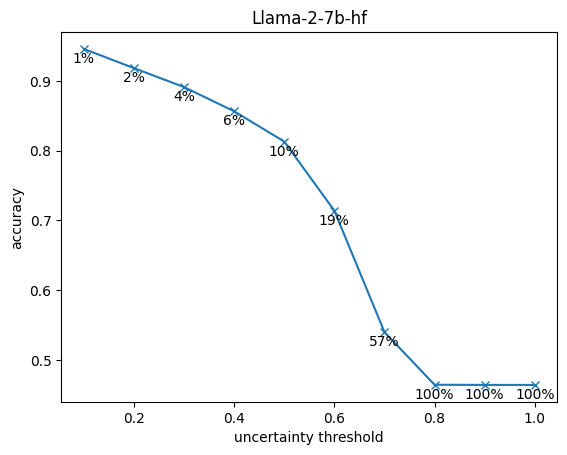

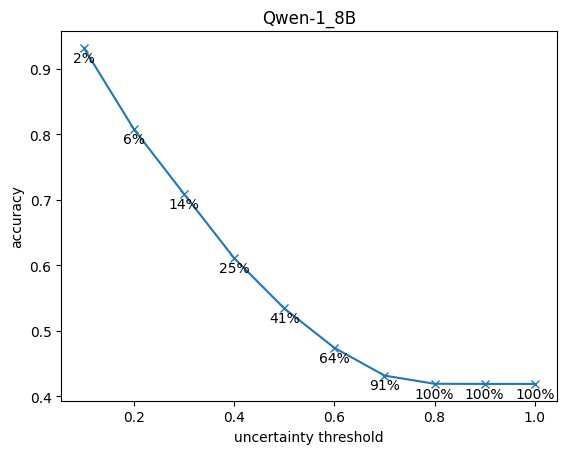

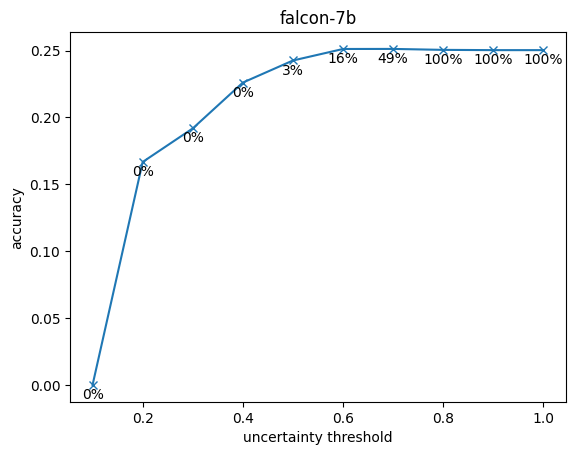

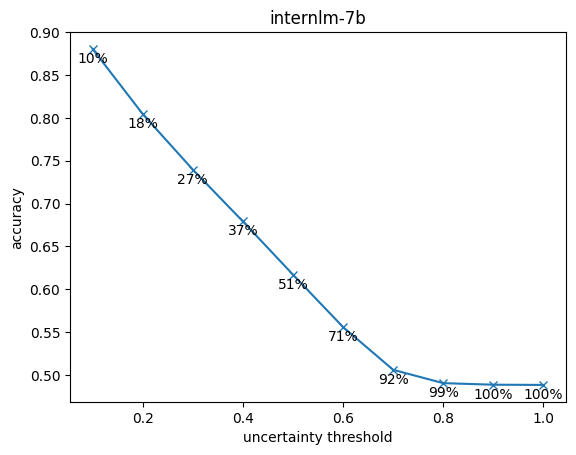

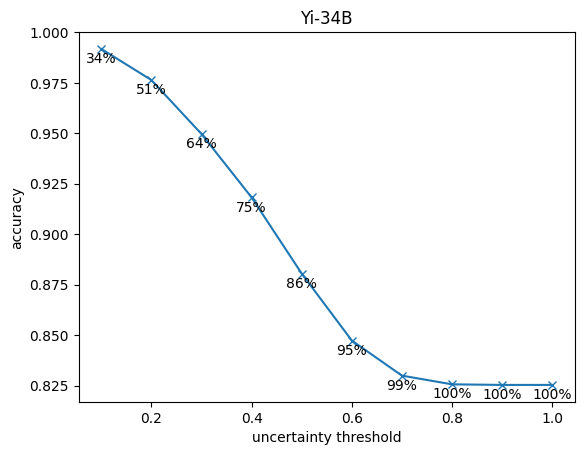

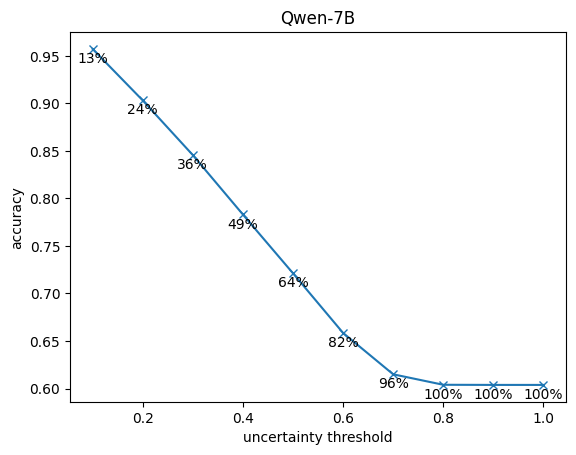

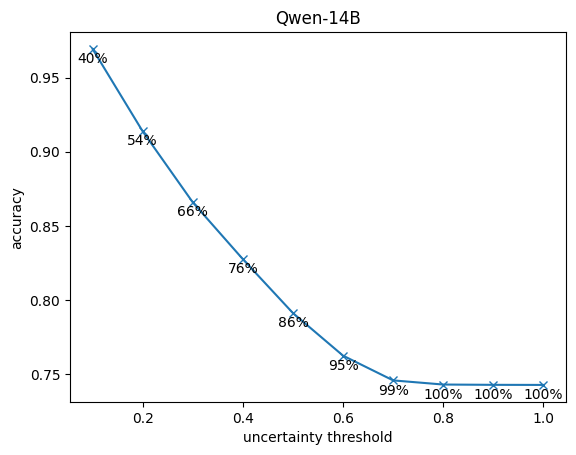

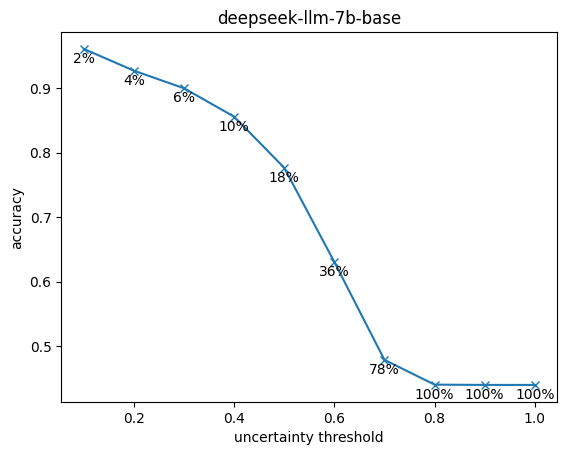

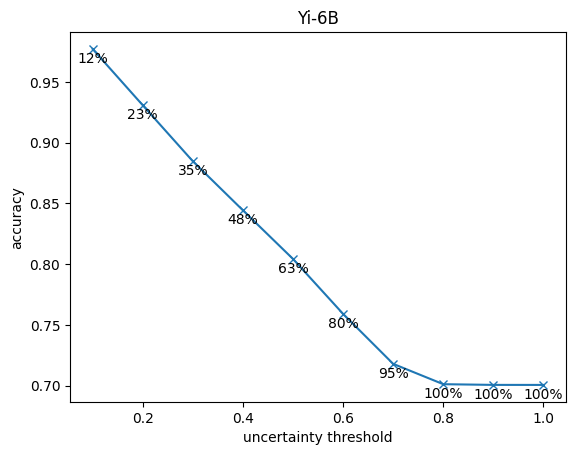

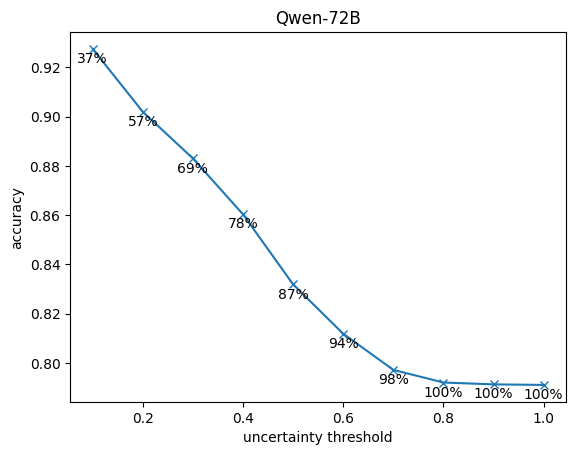

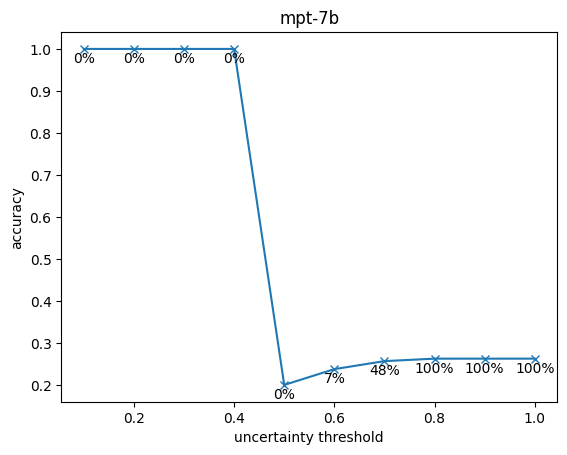

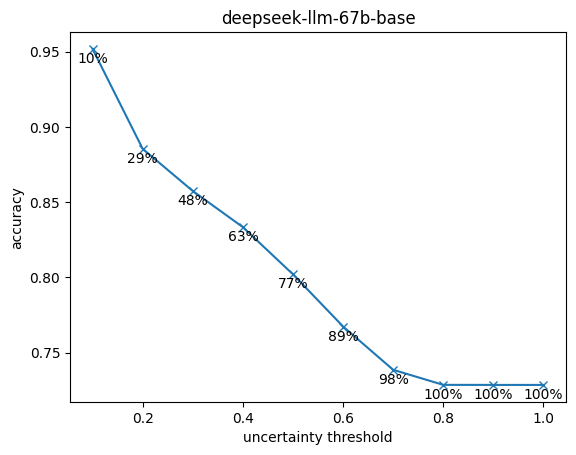

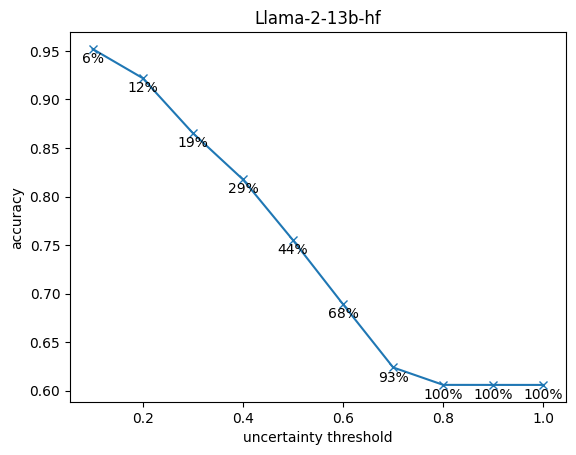

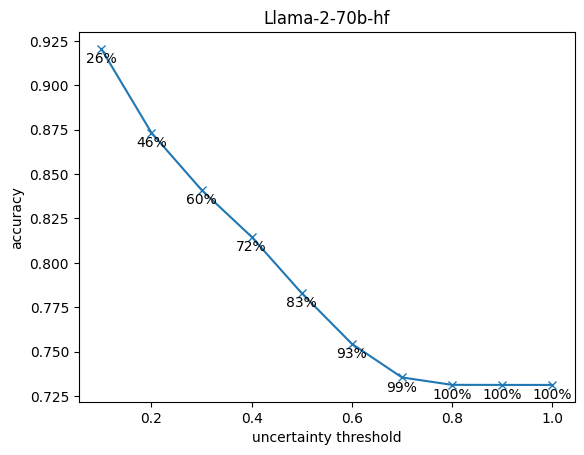

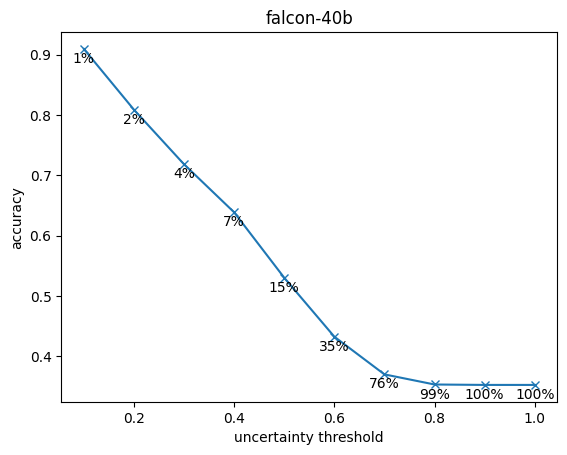

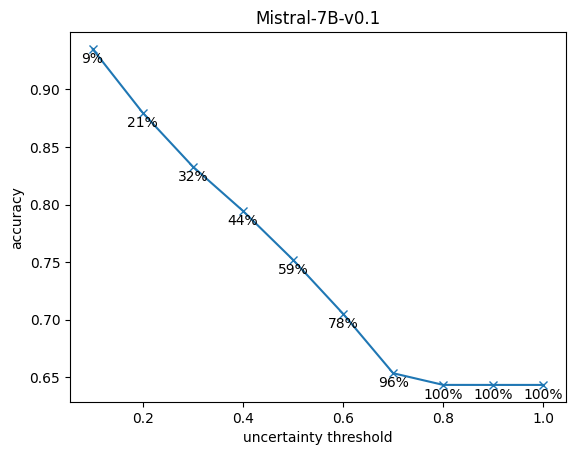

In [25]:
result = {}
for method in args.models:
    P = SPU[method].reshape(-1,SPU[method].shape[-1])[:,7].astype(int)
    U = SPU[method].reshape(-1,SPU[method].shape[-1])[:,8]
    PUT_data = np.column_stack((P, U, y))
    result[method] = uncertainty_acc_result(method, PUT_data, save=False)

In [121]:
np.sum(weights_16[:, indices], axis=1, keepdims=True)

array([[0.9815],
       [0.8702],
       [0.9625],
       ...,
       [0.9321],
       [1.1185],
       [0.8585]])

In [120]:
np.set_printoptions(suppress=True, precision=4)
weights_16[:, indices] / np.sum(weights_16[:, indices], axis=1, keepdims=True)

array([[ 0.3386,  0.1274,  0.061 ,  0.2788,  0.1411,  0.0532],
       [ 0.0462, -0.0159, -0.0043,  0.5122,  0.3319,  0.1299],
       [-0.7451,  0.4376,  0.1593,  0.5985,  0.3724,  0.1774],
       ...,
       [-0.4185,  0.7173, -0.0762, -0.4461,  0.9119,  0.3116],
       [ 0.6019, -0.8524, -0.0207,  0.5988,  0.5325,  0.1399],
       [ 0.4209,  0.1493,  0.0405,  0.1856,  0.1512,  0.0525]])

In [122]:
df_16 = pd.DataFrame(weights_16[:, indices] / np.sum(weights_16[:, indices], axis=1, keepdims=True))
df_16.describe()

,0,1,2,3,4,5
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.429281,0.135811,0.058256,0.229339,0.083437,0.063878
std,1.540051,0.991369,0.567346,1.286954,0.888345,0.409288
min,-32.871362,-44.640704,-27.901858,-33.748553,-39.853362,-15.781930
25%,0.353431,0.098132,0.030044,0.206270,0.060895,0.048160
50%,0.400000,0.152079,0.050005,0.234540,0.104223,0.069016
75%,0.472807,0.181670,0.070739,0.289221,0.133202,0.092766
max,77.920101,26.305529,20.297825,49.846786,27.560513,11.205949


In [116]:
df_6 = pd.DataFrame(weights_6)
df_6.describe()

,0,1,2,3,4,5
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.738165,0.097318,0.004776,0.161489,0.006678,-0.008426
std,5.109834,1.287868,0.730208,5.405050,2.569128,0.570035
min,-126.728798,-57.238998,-25.031000,-508.226196,-250.081207,-27.569401
25%,0.592275,0.006900,-0.035400,0.126200,0.003800,-0.030300
50%,0.690200,0.075250,-0.009100,0.171200,0.026300,-0.001900
75%,0.791725,0.173625,0.026800,0.286125,0.054525,0.022600
max,405.053802,89.416397,37.248402,67.733704,27.947001,24.976101


In [99]:
weights_16 = []
for i in range(len(y_test)):
    weight = shap_xgb_16[i, np.arange(y_test[i], shap_xgb_16.shape[1], num_model_feature), y_test[i]] 
    weight = weight / weight.sum()
    weights_16.append(np.round(weight, 4))
weights_16 = np.array(weights_16)
weights_16

array([[-0.0019,  0.0015,  0.0005, ...,  0.0522, -0.0039,  0.0184],
       [ 0.0171,  0.0332,  0.0006, ...,  0.113 ,  0.0053,  0.012 ],
       [ 0.0207, -0.0168,  0.0106, ...,  0.1707, -0.0316,  0.0341],
       ...,
       [ 0.0056, -0.0181,  0.0194, ...,  0.2904, -0.0237,  0.0309],
       [-0.0077, -0.1196, -0.0539, ...,  0.1565,  0.0388,  0.0094],
       [ 0.0226,  0.0053, -0.002 , ...,  0.0451,  0.0029,  0.0534]])

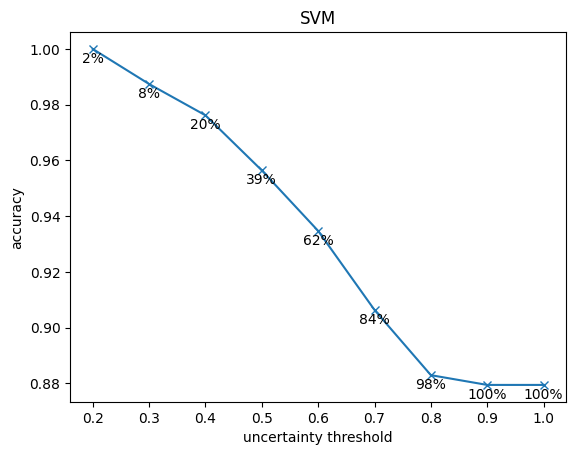

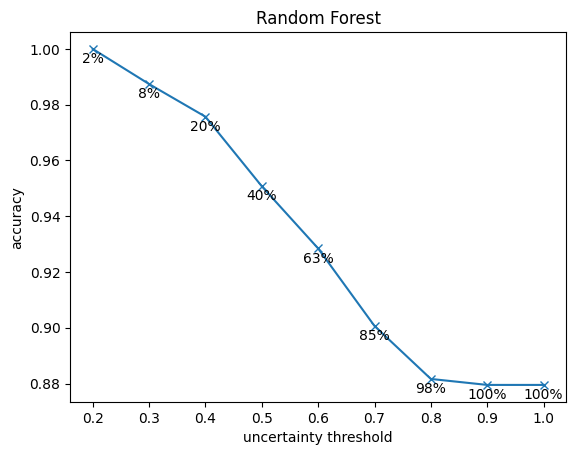

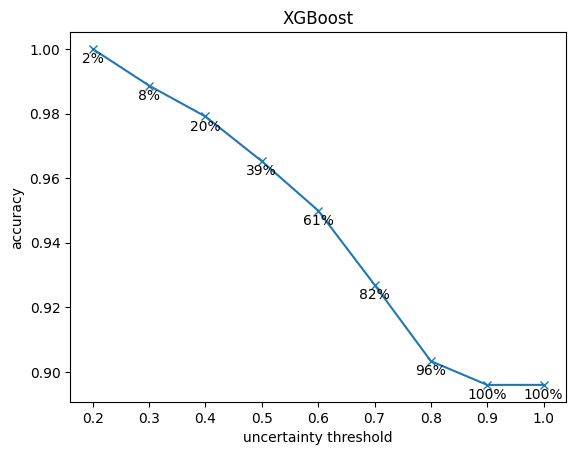

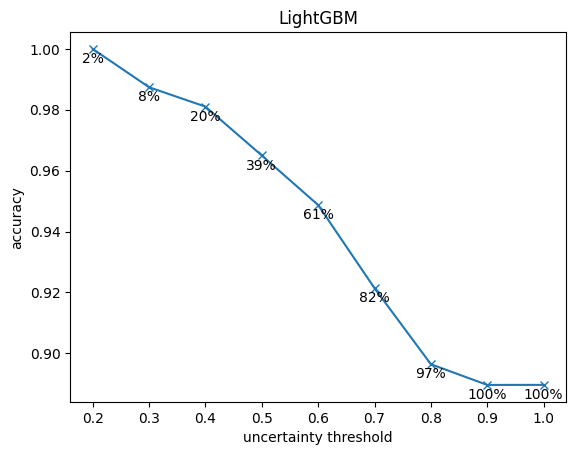

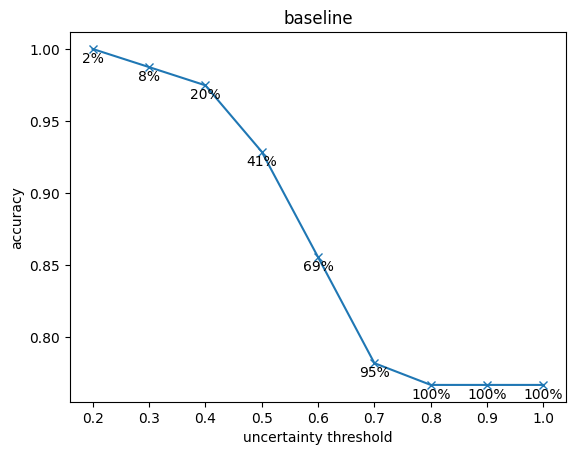

In [13]:
# dc_ml[args.models[4]] = X_test[:,4*8+6]
# for i in range(len(args.models)):
#     dc_ml[args.models[i]] = X_test[:,i*8+6]
# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# # Yi_U = 1 - test_S_avg[np.arange(len(Yi_P)), Yi_P]
# dc_ml[args.models[4]] = (1,1,Yi_P)
# dc_ml.pop(args.models[4])
baseline_pred = np.argmax(test_S_avg, axis=1)
dc_ml['baseline'] = (f1_score(y_test, baseline_pred, average='macro'), accuracy_score(y_test, baseline_pred),baseline_pred)
result = {}
for method in dc_ml.keys():
    P = dc_ml[method][2].astype(int)
    U = 1 - test_S_avg[np.arange(len(P)), P]
    PUT_data = np.column_stack((P, U, y_test))
    result[method] = uncertainty_acc_result(method, PUT_data, save=False)

# Yi_P = X_test[:,4*num_model_feature+col_model_pred].astype(int)
# Yi_U = X_test[:,4*num_model_feature+col_model_pred+1]
# PUT_data = np.column_stack((Yi_P, Yi_U, y_test))
# result['Yi_P'] = uncertainty_acc_result(method, PUT_data, cal = False)

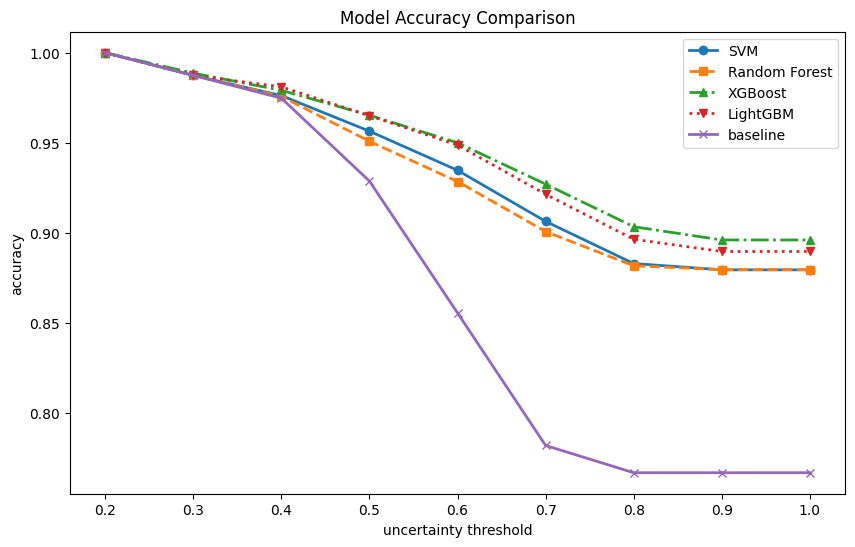

In [14]:
def plot_accuracy_multiple(models_results, title='Model Accuracy Comparison', save=True):
    """
    models_results 是一个列表，包含多个 (model_name, results) 的元组。
    model_name 是字符串，results 是对应模型的 10行3列 二维数组。
    """
    plt.figure(figsize=(10, 6))  # 设置图像大小
    linestyles = ['-', '--', '-.', ':']  # 不同的线型
    markers = ['o', 's', '^', 'v', 'x']  # 不同的标记
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 可选的颜色
    for i, model in enumerate(result):
        xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
        # # 为每个模型的每个点添加注释
        # for x, y, z in zip(xs, ys, zs):
        #     label = "{:.0f}%".format(100 * z)
        #     plt.annotate(label,  # 这个是标注的文本
        #                  (x, y),  # 这些是标注的坐标
        #                  textcoords="offset points",  # 文本的显示位置
        #                  xytext=(0, -10),  # 文本与点的距离
        #                  ha='center')  # 水平对齐方式
        # 使用不同的线型和标记，每次循环中循环使用它们
        plt.plot(xs, ys, label=model, 
                linestyle=linestyles[i % len(linestyles)],  # 循环使用线型
                marker=markers[i % len(markers)],  # 循环使用标记
                color=colors[i % len(colors)],  # 循环使用颜色
                markersize=6,  # 标记大小
                linewidth=2)  # 线宽
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    plt.legend()  # 显示图例，区分不同模型
    if save:
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_comparison/{title}.png')
        plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/fv_comparison/{title}.svg')
    plt.title(title)
    plt.show()
plot_accuracy_multiple(result,title=f'Model Accuracy Comparison', save=False)

In [15]:
dc_f1_acc = {}
print("Model Comparison:")
for method in dc_ml.keys():
    dc_f1_acc[method] = (dc_ml[method][0], dc_ml[method][1])
for id in dc_f1_acc.keys():
    print("F1-score: {:.4f}, Accuracy: {:.4f}   --{}".format(dc_f1_acc[id][0], dc_f1_acc[id][1], id))

Model Comparison:
F1-score: 0.8794, Accuracy: 0.8794   --SVM
F1-score: 0.8795, Accuracy: 0.8795   --Random Forest
F1-score: 0.8960, Accuracy: 0.8960   --XGBoost
F1-score: 0.8896, Accuracy: 0.8896   --LightGBM
F1-score: 0.7661, Accuracy: 0.7667   --baseline


In [44]:
dc_f1_acc = {}
print("Model Comparison:")
for method in dc_ml.keys():
    dc_f1_acc[method] = (dc_ml[method][0], dc_ml[method][1])
# for i in range(len(args.models)):  
#     dc_f1_acc[args.models[i]] = (f1_score(y_test, X_test[:,i*num_model_feature+col_model_pred], average='macro'), accuracy_score(y_test, X_test[:,i*num_model_feature+col_model_pred]))
for id in dc_f1_acc.keys():
    print("F1-score: {:.4f}, Accuracy: {:.4f}   --{}".format(dc_f1_acc[id][0], dc_f1_acc[id][1], id))
    
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/fv_result_json/result.json', 'w') as file:
    json.dump(result, file, indent=4)

Model Comparison:
F1-score: 0.5246, Accuracy: 0.7093   --SVM
F1-score: 0.5382, Accuracy: 0.6969   --Random Forest
F1-score: 0.5277, Accuracy: 0.6991   --XGBoost
F1-score: 0.5256, Accuracy: 0.7093   --LightGBM
F1-score: 0.5120, Accuracy: 0.7082   --CatBoost
F1-score: 0.4745, Accuracy: 0.5244   --gemma2
F1-score: 0.4972, Accuracy: 0.6539   --gemma
F1-score: 0.5149, Accuracy: 0.5298   --mistral
F1-score: 0.4919, Accuracy: 0.5954   --baseline


In [166]:
dc_f1_acc = {}
for method in args.models:
    P = SPU[method].reshape(-1,SPU[method].shape[-1])[:,7].astype(int)
    dc_f1_acc[method] = (f1_score(y, P, average='macro'), accuracy_score(y, P))
result['f1_acc'] = dc_f1_acc
for key in result.keys():
    if isinstance(result[key],dict):
        continue
    result[key] = result[key].tolist()

with open(f'D:/git-code/updated_code/ollama_fact/json_file/result_json/result_single_model.json', 'w') as file:
    json.dump(result, file, indent=4)

In [173]:
with open('D:/git-code/updated_code/ollama_fact/json_file/result_json/'+'result_14model_S.json', 'r') as file:
    data_S = json.load(file)
data_S['f1_acc']

{'SVM': [0.8779045957200038, 0.8779],
 'Random Forest': [0.8798714829723187, 0.8799],
 'XGBoost': [0.8932791748220299, 0.8933],
 'LightGBM': [0.8868764944303285, 0.8869],
 'baseline': [0.7711031173238534, 0.7715]}

In [146]:
data['f1_acc']

{'SVM': [0.8583754208052579, 0.8584],
 'Random Forest': [0.8782711068732239, 0.8783],
 'XGBoost': [0.8945889299716457, 0.8946],
 'LightGBM': [0.888666604102998, 0.8887],
 'baseline': [0.7660844153755884, 0.7667],
 'Llama-2-7b-hf': [0.4520057132040955, 0.4538],
 'Qwen-1_8B': [0.4033973771791605, 0.4127],
 'falcon-7b': [0.21608881506495264, 0.2481],
 'internlm-7b': [0.4809624730267863, 0.4884],
 'Yi-34B': [0.8286136317032085, 0.8288],
 'Qwen-7B': [0.5927285651231905, 0.5939],
 'Qwen-14B': [0.739897744884987, 0.7405],
 'deepseek-llm-7b-base': [0.4312597428146766, 0.4388],
 'Yi-6B': [0.6999130089238268, 0.7005],
 'Qwen-72B': [0.7863862084604255, 0.7864],
 'mpt-7b': [0.2406173821640506, 0.2676],
 'deepseek-llm-67b-base': [0.7221257211043925, 0.7228],
 'Llama-2-13b-hf': [0.6038190230592068, 0.6046],
 'Llama-2-70b-hf': [0.7267398470988986, 0.727],
 'falcon-40b': [0.34887790631272697, 0.3508],
 'Mistral-7B-v0.1': [0.6408086826084838, 0.6416]}

In [154]:

def dict_to_latex_table(data):
    headers = ['model','F1-score','Accuracy']
    
    latex_code = "\\begin{tabular}{" + " | ".join(['c'] * len(headers)) + "}\n\\hline\n"
    latex_code += " & ".join(headers) + " \\\\\n\\hline\n"
    for key in data.keys():
        latex_code += key
        for i in data[key]:
            # print(i)
            latex_code += " & " + str(np.round(i,4))
        latex_code+= " \\\\\n"
    latex_code += "\\hline\n\\end{tabular}"
    return latex_code

# 将 dict 转换为 LaTeX 表格
latex_table = dict_to_latex_table(data_S['f1_acc'])

# 输出 LaTeX 表格代码
print(latex_table)


\begin{tabular}{c | c | c}
\hline
model & F1-score & Accuracy \\
\hline
SVM & 0.8794 & 0.8794 \\
Random Forest & 0.8795 & 0.8795 \\
XGBoost & 0.896 & 0.896 \\
LightGBM & 0.8896 & 0.8896 \\
baseline & 0.7661 & 0.7667 \\
\hline
\end{tabular}
